TODO:

* Change to JAX `random`
* JIT the `step` function

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from scipy.special import logsumexp
import jax.numpy as np
import jax.scipy as sp
from jax import grad, jit, random
import jax
from jax.experimental.optimizers import adam
import jax.scipy.stats.norm as norm
from jax.scipy.stats import multivariate_normal
from jax.scipy.special import expit
from jax.nn import relu, sigmoid
import numpy
import math
import pdb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import sys

from nn_models import Feedforward, binary_crossentropy

In [260]:
class VAE:
    def __init__(self, decoder_architecture, encoder_architecture, x_var, random=None, decoder_weights=None, encoder_weights=None):
        '''constructor'''
        self.x_dim = decoder_architecture['output_dim']
        self.z_dim = decoder_architecture['input_dim']

        self.x_var = x_var

        assert encoder_architecture['input_dim'] == self.x_dim
        assert encoder_architecture['output_dim'] == self.z_dim * 2

        self.decoder = Feedforward(decoder_architecture, random=random, weights=decoder_weights)
        self.encoder = Feedforward(encoder_architecture, random=random, weights=encoder_weights)

        self.objective_trace = np.empty((1, 1))
        self.param_trace = np.empty((1, self.decoder.D + self.encoder.D))
        self.S = 10

        if random is not None:
            self.random = random
        else:
            self.random = numpy.random.RandomState(0)
            
    def generate(self, weights=None, N=100):
        '''use the generative model to generate x given zs sampled from the prior'''
        z_samples = self.random.normal(0, 1, size=(self.z_dim, N))

        if weights is None:
            x_samples = self.decoder.forward(self.decoder.weights, z_samples)
        else:
            x_samples = self.decoder.forward(weights, z_samples)
            
        return x_samples[0]

    def infer(self, x, weights=None):
        '''use the inference model to infer parameters of q(z|x)'''
        if weights is None:
            z = self.encoder.forward(self.encoder.weights, x)
        else:
            z = self.encoder.forward(weights, x)
            
        return z[0]
    
    def unpack_params(self, z_params):
        '''unpack variational parameters for q(z|x)'''
        assert len(z_params.shape) == 2
        assert z_params.shape[0] == 2 * self.z_dim

        mean, parametrized_var = z_params[:self.z_dim], z_params[self.z_dim:]
        std = np.exp(parametrized_var)

        return mean, std
    
    def unpack_weights(self, params):
        '''unpack the weights for the encoder and decoder'''
        assert len(params.shape) == 2
        assert params.shape[1] == self.encoder.D + self.decoder.D
        
        decoder_weights = params[:, :self.decoder.D].reshape((1, -1))
        encoder_weights = params[:, self.decoder.D:].reshape((1, -1))
        
        return encoder_weights, decoder_weights
    
    def make_objective(self, x_train, S):
        '''make variational objective function and gradient of the variational objective'''
        assert len(x_train.shape) == 2
        assert x_train.shape[0] == self.x_dim
        

        if S is not None:
            self.S = S

        N = x_train.shape[1]
        x_dummy = np.zeros((self.S, self.x_dim, N))

           
        def variational_objective(params):
            '''definition of the ELBO'''
            encoder_weights, decoder_weights = self.unpack_weights(params)

            #infer z's
            z_params = self.encoder.forward(encoder_weights, x_train)[0]
            
            #unpack var parameters
            mean, std = self.unpack_params(z_params)
            assert std.shape == (self.z_dim, N)
            assert mean.shape == (self.z_dim, N)
            
            #sample z's
            z_samples = numpy.random.normal(0, 1, size=(self.S, self.z_dim, N)) * std + mean
            assert z_samples.shape == (self.S, self.z_dim, N)
            
            #predict x's
            x = self.decoder.forward(decoder_weights, z_samples)
            assert x.shape == (self.S, self.x_dim, N)
            
            #evaluate log-likelihood
            log_likelihood = np.sum(norm.logpdf(x_train, x, self.x_var ** 0.5), axis=-2)
            assert log_likelihood.shape == (self.S, N)
                        
            #evaluate sampled z's under prior
            log_pz = np.sum(norm.logpdf(z_samples, 0.0, 1.0), axis=-2)
            assert log_pz.shape == (self.S, N)
            
            #evaluate sampled z's under variational distribution
            log_qz_given_x = np.sum(norm.logpdf(z_samples, mean, std), axis=-2)
            assert log_qz_given_x.shape == (self.S, N)
            
            #compute the elbo
            elbo = np.mean(log_likelihood - log_qz_given_x + log_pz)
            
            #return the negative elbo to be minimized
            return -elbo
            
            
        return jit(variational_objective)
    
                          
    def fit(self, x_train, S=None, params=None):
        '''minimize -ELBO'''
        assert x_train.shape[0] == self.x_dim

        ### make objective function for training
        objective = self.make_objective(x_train, S)

        ### set up optimization
        step_size = 0.01
        max_iteration = 5000
        check_point = 100
        param_init = self.random.normal(0, 0.3, size=(1, self.decoder.D + self.encoder.D))
        mass = None
        optimizer = 'adam'
        random_restarts = 1

        if 'step_size' in params.keys():
            step_size = params['step_size']
        if 'max_iteration' in params.keys():
            max_iteration = params['max_iteration']
        if 'check_point' in params.keys():
            check_point = params['check_point']
        if 'init' in params.keys():
            param_init = params['init']
        if 'call_back' in params.keys():
            call_back = params['call_back']
        if 'mass' in params.keys():
            mass = params['mass']
        if 'optimizer' in params.keys():
            optimizer = params['optimizer']
        if 'random_restarts' in params.keys():
            random_restarts = params['random_restarts']

        ### train with random restarts
        optimal_obj = 1e16
        optimal_param = param_init

        for i in range(random_restarts):
            if optimizer == 'adam':
                opt_init, opt_update, get_params = adam(step_size=step_size)
                opt_state = opt_init(param_init)
                
                def step(iteration, opt_state):
                    params = get_params(opt_state)
                    objective_val, grads = jax.value_and_grad(objective)(params)
                    self.objective_trace = np.vstack((self.objective_trace, objective_val))
                    self.param_trace = np.vstack((self.param_trace, params))
                    opt_state = opt_update(iteration, grads, opt_state)
                    if iteration % check_point == 0:
                        print(f"Iteration {iteration} lower bound {objective_val:.4f}; gradient mag: {np.linalg.norm(grads):.4f}")
                    return objective_val, opt_state

                for i in range(max_iteration):
                    objective_val, opt_state = step(i, opt_state)
                
                #adam(gradient, param_init, step_size=step_size, num_iters=max_iteration, callback=call_back)
            local_opt = np.min(self.objective_trace[1:])
            
            if local_opt < optimal_obj:
                opt_index = np.argmin(self.objective_trace[1:])
                opt_params = self.param_trace[1:][opt_index].reshape((1, -1))
                self.opt_params = opt_params
                encoder_weights, decoder_weights = self.unpack_weights(opt_params)
                self.decoder.weights = decoder_weights
                self.encoder.weights = encoder_weights
                optimal_obj = local_opt

            param_init = self.random.normal(0, 0.1, size=(1, self.decoder.D + self.encoder.D))

        self.objective_trace = self.objective_trace[1:]
        self.param_trace = self.param_trace[1:]

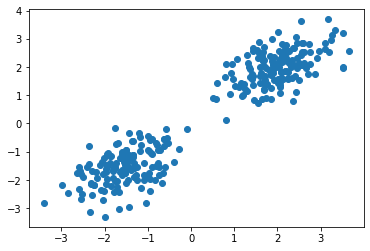

In [261]:
c_means = [[-1.5, -1.5], [2.0, 2.0]]
c_var = 0.30**2
x_var = 1e-2

indices = numpy.random.randint(2, size=300)
samples = [
    numpy.random.multivariate_normal(c_means[i], c_var * np.eye(2) + 0.2 * np.ones((2, 2))) + 
           numpy.random.multivariate_normal(np.zeros(2), x_var**0.5 * np.eye(2)) 
           for i in indices]

x_train = np.array(samples)
plt.scatter(x_train[:, 0], x_train[:, 1])
plt.show()

In [262]:
#decoder architecture
input_dim = 2
output_dim = 2
width = 50
hidden_layers = 1
activation_fn_type = 'relu'
activation_fn = relu
output_activation_type = 'linear'
output_activation_fn = lambda x: x
# activation_fn_type = 'linear'
# activation_fn = lambda x: x
decoder_architecture = {'width': [width] * hidden_layers,
                'hidden_layers': hidden_layers,
                'input_dim': input_dim,
                'output_dim': output_dim,
                'activation_fn_type': activation_fn_type,
                'activation_fn': activation_fn,
                'activation_fn_params': None,
                'output_activation_type': output_activation_type,
                'output_activation_fn': output_activation_fn,
                'task': 'regression'}


#encoder architecture
input_dim = 2
output_dim = 4
width = 50
hidden_layers = 1
# activation_fn_type = 'relu'
# activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)



encoder_architecture = {'width': [width] * hidden_layers,
                'hidden_layers': hidden_layers,
                'input_dim': input_dim,
                'output_dim': output_dim,
                'activation_fn_type': activation_fn_type,
                'activation_fn': activation_fn,
                'activation_fn_params': None,
                'output_activation_type': output_activation_type,
                'output_activation_fn': output_activation_fn,
                'task': 'regression'}

vae = VAE(decoder_architecture, encoder_architecture, x_var)

In [263]:
# x_train, _ = generate_data(N=200, var=x_var) 

params = {'step_size':1e-2,
      'max_iteration':10000,
      'random_restarts':1,
     }

vae.fit(x_train.T, params=params, S=50)

Iteration 0 lower bound 476.6485; gradient mag: 814.4680
Iteration 100 lower bound 4.8384; gradient mag: 5.3650


KeyboardInterrupt: 

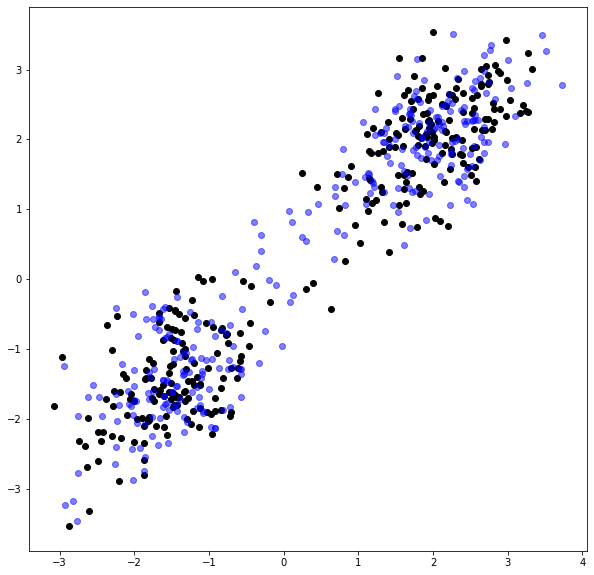

In [7]:
x_hat = vae.generate(N=300)
x_hat = x_hat + numpy.random.normal(0, x_var**0.5, size=x_hat.shape)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(x_train.T[0], x_train.T[1], color='black')
ax.scatter(x_hat[0], x_hat[1], color='blue', alpha=0.5)

plt.show()

In [8]:
width = 100
hidden_layers = 3
input_dim = 2
output_dim = 1
activation_fn_type = 'relu'
activation_fn = sigmoid
output_activation_type = 'logistic'
output_activation_fn = sigmoid

classifier_architecture = {
    'width': [width] * hidden_layers,
    'hidden_layers': hidden_layers,
    'input_dim': input_dim,
    'output_dim': output_dim,
    'activation_fn_type': activation_fn_type,
    'activation_fn': activation_fn,
    'activation_fn_params': None,
    'output_activation_type': output_activation_type,
    'output_activation_fn': output_activation_fn,
    'task': 'classification'}

classifier = Feedforward(classifier_architecture)

In [9]:
params = {'step_size':1e-4,
      'max_iteration':5000,
      'random_restarts':1,
     }

X = np.array(samples)
X_mean = X.mean()
X_std = X.std()
X_train = (X - X_mean) / X_std
classifier.fit(X_train.T, indices.reshape(1,-1), params)

Iteration 0 lower bound 1181.3038; gradient mag: 1932.1658
Iteration 100 lower bound 314.0270; gradient mag: 1415.0798
Iteration 200 lower bound 50.5938; gradient mag: 384.4337
Iteration 300 lower bound 20.1628; gradient mag: 152.3316
Iteration 400 lower bound 11.1862; gradient mag: 80.4320
Iteration 500 lower bound 6.8273; gradient mag: 45.9864
Iteration 600 lower bound 4.2388; gradient mag: 25.2322
Iteration 700 lower bound 2.9121; gradient mag: 13.5483
Iteration 800 lower bound 2.3482; gradient mag: 8.5708
Iteration 900 lower bound 2.0702; gradient mag: 6.4132
Iteration 1000 lower bound 1.8969; gradient mag: 5.2586
Iteration 1100 lower bound 1.7686; gradient mag: 4.5255
Iteration 1200 lower bound 1.6629; gradient mag: 3.9940
Iteration 1300 lower bound 1.5704; gradient mag: 3.5671
Iteration 1400 lower bound 1.4866; gradient mag: 3.1965
Iteration 1500 lower bound 1.4085; gradient mag: 2.8559
Iteration 1600 lower bound 1.3337; gradient mag: 2.5319
Iteration 1700 lower bound 1.2619; gra

In [10]:
classifier.weight_trace[-1]

DeviceArray([ 1.8014764 ,  0.4532501 ,  0.95778805, ...,  0.60514677,
             -0.27902433,  0.7830518 ], dtype=float32)

In [11]:
classifier.D

20601

In [12]:
classifier.weight_trace[-1].reshape(1, -1).shape

(1, 20601)

In [13]:
preds = classifier.predict(X_train)

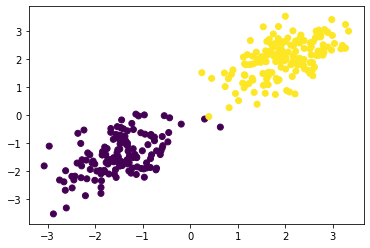

In [14]:
plt.scatter(x_train.T[0], x_train.T[1], c=indices)

plt.show()

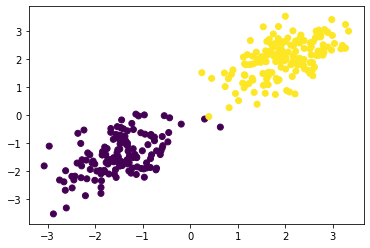

In [15]:
plt.scatter(x_train.T[0], x_train.T[1], c=preds)

plt.show()

In [211]:
chosen_point = x_train[5].T

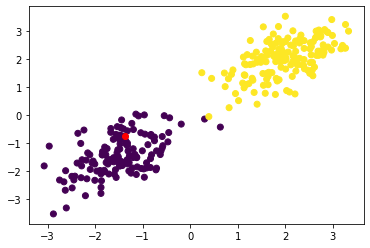

In [212]:
plt.scatter(x_train.T[0], x_train.T[1], c=indices)
plt.scatter(*chosen_point, color='red')

plt.show()

In [213]:
chosen_point

DeviceArray([-1.3708237 , -0.75808644], dtype=float32)

In [49]:
prediction = classifier.predict(chosen_point.reshape(1,-1))
def calc_distance(x1, x2):
    return np.linalg.norm(x1 - x2, ord=2)
    
#while not prediction:
chosen_z = vae.infer(chosen_point.reshape(1,-1).T)[:vae.z_dim,0]
chosen_z

DeviceArray([-1.7920407 ,  0.21786393], dtype=float32)

In [50]:
reconstructed_x = vae.decoder.forward(vae.decoder.weights.reshape(1,-1), chosen_z.reshape(1,-1).T).reshape(1,-1).squeeze()
reconstructed_x

DeviceArray([-2.2705164, -2.2399042], dtype=float32)

In [51]:
chosen_point.reshape(1,-1)

DeviceArray([[-2.2939904, -2.239346 ]], dtype=float32)

In [52]:
distance = calc_distance(chosen_point, reconstructed_x)
distance

DeviceArray(0.02348061, dtype=float32)

In [62]:
gamma = 1e-5
distance_term = gamma * distance
distance_term

DeviceArray(2.3480612e-07, dtype=float32)

In [63]:
reconstructed_prob = classifier.predict_proba(reconstructed_x.reshape(1, -1))
reconstructed_prob

DeviceArray(4.653032e-05, dtype=float32)

In [64]:
loss = binary_crossentropy(np.array([1]), reconstructed_prob.reshape(1,-1))
loss

DeviceArray(9.975407, dtype=float32)

In [65]:
objective = loss + distance_term
objective

DeviceArray(9.975407, dtype=float32)

In [242]:
def revise_objective(chosen_point, chosen_z, vae, classifier, gamma):
    reconstructed_x = vae.decoder.forward(vae.decoder.weights.reshape(1,-1), chosen_z.reshape(1,-1).T).reshape(1,-1).squeeze()
    distance = calc_distance(chosen_point, reconstructed_x)
    distance_term = gamma * distance
    reconstructed_prob = classifier.predict_proba(reconstructed_x.reshape(1, -1))
    loss = binary_crossentropy(np.array([1]), reconstructed_prob.reshape(1,-1))
    objective = loss + distance_term
    return objective, (reconstructed_x, reconstructed_prob)

In [81]:
grad_z, (reconstructed_x, reconstructed_prob) = grad(revise_objective, 1, has_aux=True)(chosen_point, chosen_z, vae, classifier, gamma)

In [245]:
chosen_z

NameError: name 'chosen_z' is not defined

In [83]:
chosen_point, reconstructed_x

(DeviceArray([-2.2939904, -2.239346 ], dtype=float32),
 DeviceArray([-2.2705164, -2.2399042], dtype=float32))

In [246]:
from tqdm.notebook import tqdm
chosen_point = x_train[5].T
new_z = vae.infer(chosen_point.reshape(1,-1).T)[:vae.z_dim,0]

max_iter = 200
learning_rate = 1e-3
gamma = 0
i = 0
reconstructed_prob = 0
min_prob_of_positive = 0.5
zs = [new_z]
xs = [chosen_point]
probs = []
grads = []
pbar = tqdm(total=max_iter, smoothing=0)
while i < max_iter and reconstructed_prob < min_prob_of_positive:
    grad_z, (reconstructed_x, reconstructed_prob) = grad(revise_objective, 1, has_aux=True)(chosen_point, new_z, vae, classifier, gamma)
    new_z -= learning_rate * grad_z
    zs.append(new_z)
    xs.append(reconstructed_x)
    probs.append(reconstructed_prob)
    grads.append(grad_z)
    pbar.update()
    i += 1
pbar.close()

In [247]:
import pandas as pd
pd.Series(xs)

0      [-1.3708237, -0.75808644]
1      [-1.3982205, -0.79178625]
2       [-1.3986467, -0.7915825]
3       [-1.3990715, -0.7913771]
4       [-1.3994956, -0.7911708]
                 ...            
196    [-1.5852072, -0.83148485]
197    [-1.5855238, -0.83080596]
198      [-1.585734, -0.8301709]
199    [-1.5872728, -0.83126146]
200      [-1.5875866, -0.830581]
Length: 201, dtype: object

<AxesSubplot:>

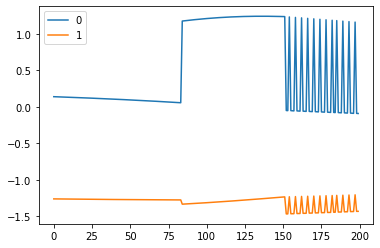

In [248]:
pd.DataFrame(grads).plot.line()

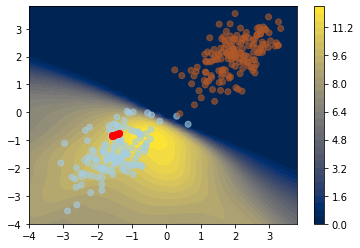

In [249]:
plt.contourf(x, y, loss, levels=30, cmap='cividis')
plt.colorbar()
plt.scatter(x_train.T[0], x_train.T[1], c=indices, alpha=0.6, cmap='Paired')
plt.scatter(*chosen_point, color='red')
path = np.array(xs)
plt.plot(path[::20,0], path[::20,1], c='red', marker='o', alpha=1)

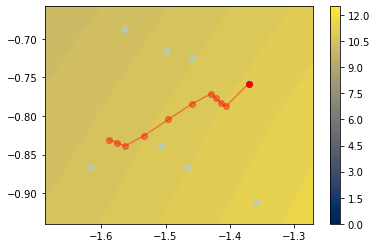

In [251]:
plt.contourf(x, y, loss, levels=60, cmap='cividis')
plt.colorbar()
plt.scatter(x_train.T[0], x_train.T[1], c=indices, alpha=0.6, cmap='Paired')
plt.scatter(*chosen_point, color='red')
path = np.array(xs)
plt.xlim(path[:,0].min() - .1, path[:,0].max() + .1)
plt.ylim(path[:,1].min() - .1, path[:,1].max() + .1)

plt.plot(path[::20,0], path[::20,1], c='red', marker='o', alpha=0.4)

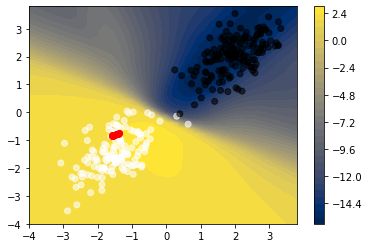

In [230]:
chosen_point = x_train[5].T
plt.contourf(x, y, np.log(loss), levels=30, cmap='cividis')
plt.colorbar()
plt.scatter(x_train.T[0], x_train.T[1], c=indices, alpha=0.6, cmap='binary')
plt.scatter(*chosen_point, color='red')
plt.plot(np.array(xs)[::20,0], np.array(xs)[::20,1], c='red', marker='o', alpha=1)

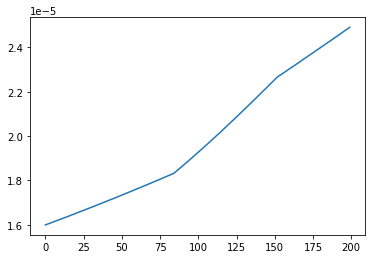

In [239]:
plt.plot(probs)

In [142]:
x, y = numpy.mgrid[-4:4:0.2,-4:4:0.2]
pos = numpy.dstack((x, y))
loss = numpy.apply_along_axis(lambda coord: classifier.predict_proba(np.array(coord).reshape(1, -1)), 2, pos)

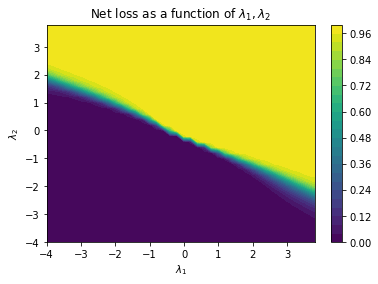

In [145]:
plt.contourf(x, y, loss, levels=30)
plt.colorbar()
plt.xlabel('$\lambda_1$')
plt.ylabel('$\lambda_2$')
_ = plt.title('Net loss as a function of $\lambda_1,\lambda_2$')

In [190]:
x, y = numpy.mgrid[-4:4:0.2,-4:4:0.2]
pos = numpy.dstack((x, y))
loss = numpy.apply_along_axis(lambda coord: binary_crossentropy(np.array([1]), classifier.predict_proba(np.array(coord).reshape(1, -1)).reshape(1,-1)), 2, pos)

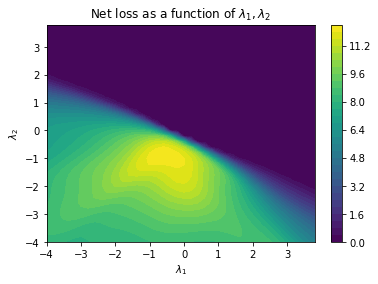

In [191]:
plt.contourf(x, y, loss, levels=30)
plt.colorbar()
plt.xlabel('$\lambda_1$')
plt.ylabel('$\lambda_2$')
_ = plt.title('Net loss as a function of $\lambda_1,\lambda_2$')

In [190]:
x, y = numpy.mgrid[-4:4:0.2,-4:4:0.2]
pos = numpy.dstack((x, y))
in_data = numpy.apply_along_axis(
    lambda coord: binary_crossentropy(np.array([1]), classifier.predict_proba(np.array(coord).reshape(1, -1)).reshape(1,-1)), 2, pos)

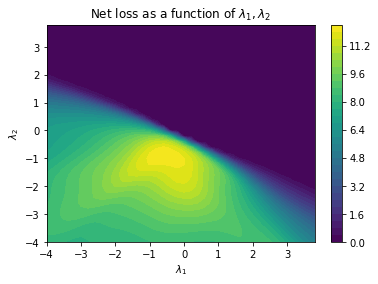

In [191]:
plt.contourf(x, y, loss, levels=30)
plt.colorbar()
plt.xlabel('$\lambda_1$')
plt.ylabel('$\lambda_2$')
_ = plt.title('Net loss as a function of $\lambda_1,\lambda_2$')